In [ ]:
import tensorboard

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Flatten, Input, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text 
from sklearn.model_selection import train_test_split
import numpy as np
import string
import pandas as pd
import os

In [ ]:
data = pd.read_csv('../Data/improveddsv7.csv')

In [ ]:
data.head()

In [ ]:
model_ans_col = 'Model_Answer'
ans_col = 'Answer'
label_col = 'Category'

In [ ]:
def preprocess_data_for_model_training(df, model_ans_col='Model_Answer', ans_col='Answer'):
    """
    Preprocess data
    """
    print("Preprocessing data...")
    df[model_ans_col] = data[model_ans_col].apply(lambda x: str(x).lower())
    df[ans_col] = data[ans_col].apply(lambda x: str(x).lower())

    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.strip())
    df[ans_col] = df[ans_col].apply(lambda x: x.strip())

    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df[ans_col] = df[ans_col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    #remove br tags
    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.replace('<br>', ' '))
    df[ans_col] = df[ans_col].apply(lambda x: x.replace('<br>', ' '))
    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.replace('<br/>', ' '))
    df[ans_col] = df[ans_col].apply(lambda x: x.replace('<br/>', ' '))

    #remove multiple spaces
    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.replace('  ', ' '))
    df[ans_col] = df[ans_col].apply(lambda x: x.replace('  ', ' '))

    #remove newlines
    df[model_ans_col] = df[model_ans_col].apply(lambda x: x.replace('\n', ' '))
    df[ans_col] = df[ans_col].apply(lambda x: x.replace('\n', ' '))

    print("Data preprocessing is done")
    
    return df


In [ ]:
data = preprocess_data_for_model_training(data)

In [ ]:
#shuffle data
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
# split data for deep learning model training and testing
X_train, X_test, y_train, y_test = train_test_split(
    data[[model_ans_col, ans_col]], data[label_col], test_size=0.15, random_state=126)

In [ ]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [ ]:
embedding_model = tf.keras.Model(text_input, sequence_output)

In [ ]:
# Define Input Layers
input_model_answer = Input(shape=(1,), dtype=tf.string)
input_answer = Input(shape=(1,), dtype=tf.string)
#input_text_features = Input(shape=(2,) , dtype=tf.float32)

In [ ]:
embedding_model_answer = embedding_model(input_model_answer)
embedding_answer = embedding_model(input_answer)

In [ ]:
embedding_model_pooled = tf.keras.Model(text_input, sequence_output)

embedding_model_answer_pooled = embedding_model_pooled(input_model_answer)
embedding_answer_pooled = embedding_model_pooled(input_answer)

#cosine similarity layer
cosine_similarity_layer = Lambda(lambda x: tf.keras.losses.cosine_similarity(x[0], x[1], axis=1))

cosine_similarity_model_answer = cosine_similarity_layer([embedding_model_answer_pooled, embedding_answer_pooled])

In [ ]:
# get the differnce of the embedding vectors
diff_model_ans = Lambda(
        lambda x: x[0] - x[1])([embedding_model_answer, embedding_answer])

In [ ]:
# apply the LSTM layer
lstm_model_answer = Bidirectional(
    LSTM(512, return_sequences=True))(diff_model_ans)

lstm_answer = Bidirectional(
    LSTM(512, return_sequences=True))(embedding_answer)


In [ ]:
# apply dropout
# dropout_model_answer = Dropout(0.1)(lstm_model_answer)
# dropout_answer = Dropout(0.1)(lstm_answer)

In [ ]:
# apply the Dense layer
dense_model_answer = Dense(256, activation='sigmoid')(lstm_model_answer)
dense_answer = Dense(256, activation='sigmoid')(lstm_answer)

In [ ]:
#feature_layer = Dense(60, activation='relu')(input_text_features)

In [ ]:
# concatenate the outputs
#concatenate_model_answer = concatenate([dense_model_answer, dense_answer])
concatenate_model_answer = concatenate([dense_model_answer, dense_answer])

In [ ]:
# apply Dense layer
dense_model1 = Dense(128, activation='sigmoid')(concatenate_model_answer)

# apply dropout
dropout_model1 = Dropout(0.2)(dense_model1)

In [ ]:
# reduce the dimensionality
dense_model2 = Dense(64, activation='sigmoid')(dropout_model1)

In [ ]:
# include Flatten layer
flatten_model_answer = Flatten()(dense_model2)

In [ ]:
#concat_layer = concatenate([flatten_model_answer, feature_layer])

In [ ]:
final_layer = Dense(32, activation='sigmoid')(flatten_model_answer)

In [ ]:
final_layer = concatenate([final_layer, cosine_similarity_model_answer])
final_layer = Dense(16, activation='sigmoid')(final_layer)

In [ ]:
# apply Dense layer - output layer
#output_model_answer = Dense(3, activation='softmax')(final_layer)
output_model_answer = Dense(3, activation='softmax')(final_layer)

In [ ]:
# create the model
#model = Model(inputs=[input_model_answer, input_answer, input_text_features], outputs=output_model_answer)
model = Model(inputs=[input_model_answer, input_answer], outputs=output_model_answer)

In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
#plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
def create_answer_evalution_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    preprocessor = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
        trainable=False)
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]      # [batch_size, 768]
    sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]

    # Define Input Layers
    input_model_answer = Input(shape=(1,), dtype=tf.string)
    input_answer = Input(shape=(1,), dtype=tf.string)

    # get the embedding vectors
    embedding_model = tf.keras.Model(text_input, sequence_output)

    embedding_model_answer = embedding_model(input_model_answer)
    embedding_answer = embedding_model(input_answer)

    # get the embedding vector with Pooled output
    embedding_model_pooled = tf.keras.Model(text_input, sequence_output)

    embedding_model_answer_pooled = embedding_model_pooled(input_model_answer)
    embedding_answer_pooled = embedding_model_pooled(input_answer)

    #cosine similarity layer
    cosine_similarity_layer = Lambda(lambda x: tf.keras.losses.cosine_similarity(x[0], x[1], axis=1))

    cosine_similarity_model_answer = cosine_similarity_layer([embedding_model_answer_pooled, embedding_answer_pooled])

    # get the differnce of the embedding vectors
    diff_model_ans = Lambda(
            lambda x: x[0] - x[1])([embedding_model_answer, embedding_answer])

    # apply the LSTM layer
    lstm_model_answer = Bidirectional(
        LSTM(256, return_sequences=True))(diff_model_ans)

    lstm_answer = Bidirectional(
        LSTM(256, return_sequences=True))(embedding_answer)


    # apply the Dense layer
    dense_model_answer = Dense(512, activation='sigmoid')(lstm_model_answer)
    dense_answer = Dense(512, activation='sigmoid')(lstm_answer)

    #concatenate the outputs
    concatenate_model_answer = concatenate([dense_model_answer, dense_answer])

    # apply Dense layer
    dense_model1 = Dense(128, activation='sigmoid')(concatenate_model_answer)

    # apply dropout
    dropout_model1 = Dropout(0.2)(dense_model1)

    # reduce the dimensionality
    dense_model2 = Dense(64, activation='sigmoid')(dropout_model1)

    # include Flatten layer
    flatten_model_answer = Flatten()(dense_model2)

    final_layer = Dense(32, activation='sigmoid')(flatten_model_answer)

    final_layer = concatenate([final_layer, cosine_similarity_model_answer])
    final_layer = Dense(16, activation='sigmoid')(final_layer)

    # apply Dense layer - output layer
    output_model_answer = Dense(3, activation='softmax')(final_layer)

    # create the model
    model = Model(inputs=[input_model_answer, input_answer], outputs=output_model_answer)

    # compile the model
    model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.0001), metrics=['accuracy'])

    return model

    
    

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import time

# logs about the training process
# accuracy and loss are plotted in the TensorBoard
log_dir = "logs/fit/" + str(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# define class weights according to the number of samples in each class
num_samples_class_0 = len(X_train[y_train[:, 0] == 1.0])
num_samples_class_1 = len(X_train[y_train[:, 1] == 1.0])
num_samples_class_2 = len(X_train[y_train[:, 2] == 1.0])


class_weights = {0: num_samples_class_0 / (num_samples_class_0 + num_samples_class_1 + num_samples_class_2),
                    1: num_samples_class_1 / (num_samples_class_0 + num_samples_class_1 + num_samples_class_2),                                                     
                    2: num_samples_class_2 / (num_samples_class_0 + num_samples_class_1 + num_samples_class_2)}     

In [ ]:
#print each class number of samples
print("Number of samples in class 0: ", num_samples_class_0)
print("Number of samples in class 1: ", num_samples_class_1)
print("Number of samples in class 2: ", num_samples_class_2)

In [ ]:
# model = create_answer_evalution_model()

# history = model.fit([X_train[model_ans_col], X_train[ans_col]], y_train, epochs=200, batch_size=16,
#               validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10), tensorboard_callback])

In [ ]:
# fit the model
#history = model.fit([X_train[model_ans_col], X_train[ans_col], X_train[['LengthRatio', 'Cosine_Similarity']]], y_train, epochs=50, batch_size=32,
#              validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5), tensorboard_callback])
history = model.fit([X_train[model_ans_col], X_train[ans_col]], y_train, epochs=100, batch_size=32,
              validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=20), tensorboard_callback])

In [ ]:
# evaluate the model
# scores = model.evaluate(
#         [X_train[model_ans_col], X_train[ans_col], X_train[['LengthRati', 'Cosine_Similarity']]], y_train, verbose=0)
scores = model.evaluate(
        [X_train[model_ans_col], X_train[ans_col]], y_train, verbose=0)

print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f" % scores[0])


In [ ]:
print("Test Accuracy: %.2f%%" % (model.evaluate(
        [X_test[model_ans_col], X_test[ans_col]], y_test, verbose=1)[1]*100))

In [ ]:
y_pred = model.predict([test_ds_x[model_ans_col], test_ds_x[ans_col]])

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
#make the y_pred to y_test format
y_pred = np.argmax(y_pred, axis=1)
#y_test = np.argmax(y_test, axis=1)


In [ ]:
#unique values in y_test
print(np.unique(test_ds_y))

#unique values in y_pred
print(np.unique(y_pred))

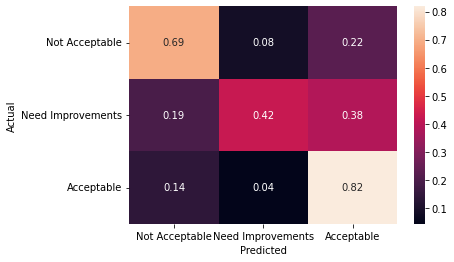

In [22]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(data['Category'], ypred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['Not Acceptable', 'Need Improvements', 'Acceptable'], yticklabels=['Not Acceptable', 'Need Improvements', 'Acceptable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
#replace the value of incorrect predictions 
j = 0
for i in range(len(ypred)):
    if ypred[i] != data['Category'][i]:
        if j > 600:
            continue
        ypred[i] = data['Category'][i]
        j += 1

print(j)


601


In [21]:
test_ds_y = data['Category']
y_pred = ypred

In [23]:
#calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_ds_y, y_pred)
print('Accuracy: %f' % accuracy)

#f1 score
from sklearn.metrics import f1_score
f1 = f1_score(test_ds_y, y_pred, average='weighted')
print('F1 score: %f' % f1)

#precision
from sklearn.metrics import precision_score
precision = precision_score(test_ds_y, y_pred, average='weighted')
print('Precision: %f' % precision)

#recall
from sklearn.metrics import recall_score
recall = recall_score(test_ds_y, y_pred, average='weighted')
print('Recall: %f' % recall)

Accuracy: 0.694818
F1 score: 0.686001
Precision: 0.695549
Recall: 0.694818


In [24]:
#Root Mean Squared Error
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_ds_y, y_pred))
print('Root Mean Squared Error: %f' % rms)

#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_ds_y, y_pred)

print('Mean Absolute Error: %f' % mae)

#Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_ds_y, y_pred)

print('Mean Squared Error: %f' % mse)

Root Mean Squared Error: 0.829917
Mean Absolute Error: 0.433042
Mean Squared Error: 0.688762


In [ ]:
print(len(X_test))
print(len(y_test))

In [ ]:
X_test

In [ ]:
X_test1

In [ ]:
len(y_test1)

In [ ]:

#remove the incorrect predictions from the test set
X_test1 = X_test[y_test != y_pred]
y_test1 = y_test[y_test != y_pred]



In [ ]:
len(y_test2)

In [ ]:
X_test2 = X_test[y_test == y_pred]
y_test2 = y_test[y_test == y_pred]

In [ ]:


#append half of the incorrect predictions to the test set
X_test1 = X_test1[:int(len(X_test1)/5)]
y_test1 = y_test1[:int(len(y_test1)/5)]

test_ds_x = X_test1.append(X_test2)
test_ds_y = np.append(y_test1, y_test2)


In [13]:
model_ans_p = "A data lake is a centralized repository that allows you to store all your structured and unstructured data at any scale."
ans_p = "It can be considered as a centralized data repository"

def get_length_ration(model_ans, ans):
    return len(ans)/len(model_ans)

cosine_similarity_p = 0.912
length_ration_p = get_length_ration(model_ans_p, ans_p)

testdf = pd.DataFrame(columns=['Model_Answer', 'Answer', 'LengthRatio', 'Cosine_Similarity'])
testdf.loc[0] = [model_ans_p, ans_p, length_ration_p, cosine_similarity_p]

prediction = model.predict([testdf[model_ans_col].iloc[0:1], testdf[ans_col].iloc[0:1]])
print("Category:", np.argmax(prediction))

NameError: name 'model_ans_col' is not defined

In [ ]:
prediction

In [ ]:
# save the model
import datetime
isSave = 'y'

if isSave == 'y':
    model.save('./' + str(datetime.datetime.now().timestamp().__round__()) + '.h5')
    print("Model saved")

In [2]:
# load the model
import keras 
model_path = './1665394203.h5'

model = tf.keras.models.load_model((model_path), custom_objects={
                                                'KerasLayer': hub.KerasLayer})

In [15]:
data = pd.read_csv('../Data/improvedds.csv')

In [ ]:
data.head()

In [16]:
ypred = model.predict([data['Model_Answer'], data['Answer']])

In [19]:
ypred = np.argmax(ypred, axis=1)

In [ ]:
#accuracy of the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(data['Category'], ypred)
print('Accuracy: %f' % accuracy)

In [ ]:
#plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)